In [26]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase

torch.manual_seed(0)


### Getting the data for training

In [90]:
# ground truth system model
gt_model = psl.nonautonomous.VanDerPolControl()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = -5.
umax = 5.
xmin = -4.
xmax = 4.


In [91]:
def get_policy_data(nsteps, n_samples):
    # Training dataset generation
    train_data = DictDataset({'xn': torch.randn(n_samples, 1, nx),
                          'r': torch.zeros(n_samples, nsteps+1, nx)}, name='train')
    # Development dataset generation
    dev_data = DictDataset({'xn': torch.randn(n_samples, 1, nx),
                        'r': torch.zeros(n_samples, nsteps+1, nx)}, name='dev')
    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn, shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn, shuffle=False)
    return train_loader, dev_loader

nsteps = 50  # prediction horizon
n_samples = 2000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)



### DPC Closed Loop

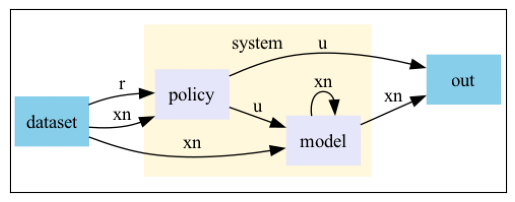

In [93]:
# white-box ODE model with no-plant model mismatch
van_der_pol = ode.VanDerPolControl()                   # ODE system equations implemented in PyTorch
van_der_pol.mu = nn.Parameter(torch.tensor(gt_model.mu), requires_grad=False)

# integrate continuous time ODE
integrator = integrators.RK4(van_der_pol, h=torch.tensor(ts))   # using 4th order runge kutta integrator

# symbolic system model
integrator_node = Node(integrator, ['xn', 'u'], ['xn'], name='model')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xn', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, integrator_node], nsteps=nsteps)
cl_system.show()

In [101]:
# variables
x = variable('xn')
ref = variable("r")
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)

# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'

# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
]

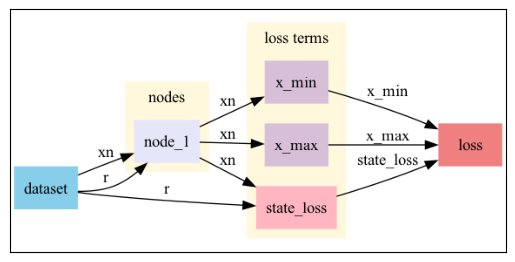

In [102]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()


In [96]:

optimizer = torch.optim.AdamW(policy.parameters(), lr=0.005)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=1000,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=100,
    patience=100,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)


epoch: 0  train_loss: 5.763289451599121
epoch: 1  train_loss: 1.8238790035247803
epoch: 2  train_loss: 0.9803255200386047
epoch: 3  train_loss: 0.809911847114563
epoch: 4  train_loss: 0.7523618936538696
epoch: 5  train_loss: 0.7361685037612915
epoch: 6  train_loss: 0.7268569469451904
epoch: 7  train_loss: 0.7207695841789246
epoch: 8  train_loss: 0.7161116600036621
epoch: 9  train_loss: 0.7124096751213074
epoch: 10  train_loss: 0.709406316280365
epoch: 11  train_loss: 0.7068814039230347
epoch: 12  train_loss: 0.7047325372695923
epoch: 13  train_loss: 0.7028847932815552
epoch: 14  train_loss: 0.7012888193130493
epoch: 15  train_loss: 0.6999031901359558
epoch: 16  train_loss: 0.698694109916687
epoch: 17  train_loss: 0.6976343989372253
epoch: 18  train_loss: 0.6967016458511353
epoch: 19  train_loss: 0.6958773732185364
epoch: 20  train_loss: 0.6951459646224976
epoch: 21  train_loss: 0.6944946646690369
epoch: 22  train_loss: 0.6939126253128052
epoch: 23  train_loss: 0.6933907270431519
epoch:

<All keys matched successfully>

In [42]:
nsteps_test = 100
torch.manual_seed(22)
data = {'xn': torch.randn(1, 1, nx, dtype=torch.float32),
        'r': torch.zeros(1, nsteps_test+1, nx, dtype=torch.float32)}
cl_system.nsteps = nsteps_test

import time
nn_times = []
trajectories = None
for i in range(50):
    start = time.time()
    # perform closed-loop simulation
    trajectories = cl_system(data)
    total = time.time() - start
    nn_times.append(total)


(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

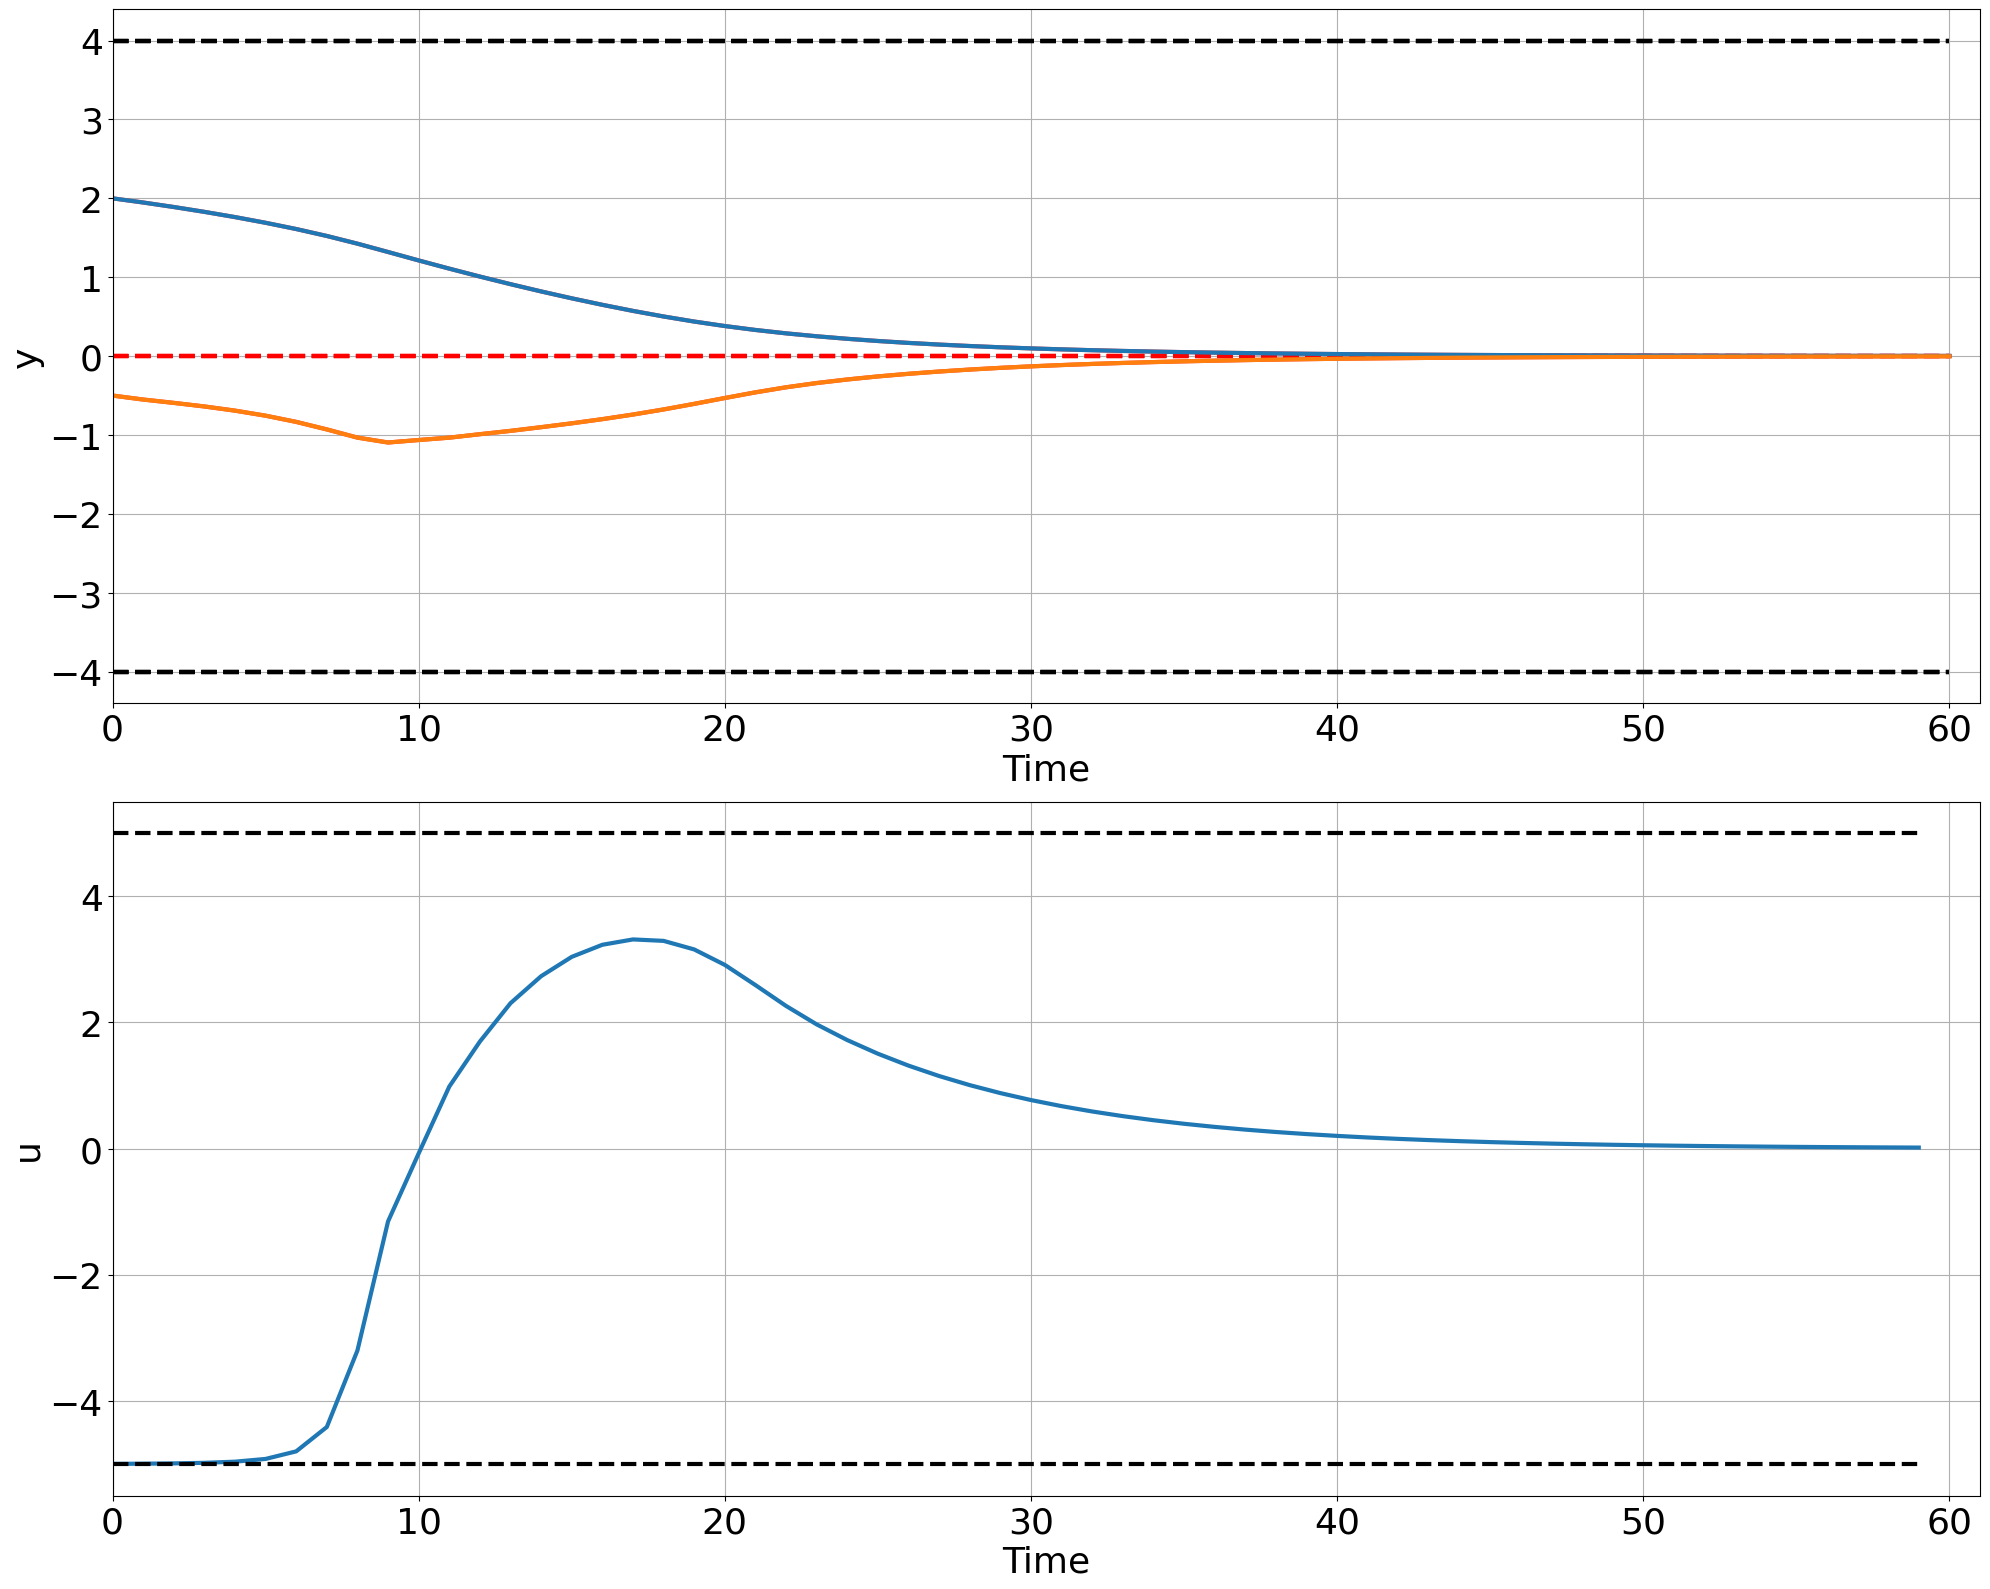

In [144]:
nsteps = 60
# generate reference
torch_ref = torch.zeros(1, nsteps+1, nx, dtype=torch.float32)
# generate initial data for closed loop simulation
data = {'xn': torch.tensor([[[2.,-0.5]]], dtype=torch.float32),
        'r': torch_ref}
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

### Online Adaptation

#### Now, lets add some noise to the ODE parameters

In [142]:
noise_level = 10
noise = torch.randn(1) * noise_level
van_der_pol.mu = nn.Parameter(torch.tensor(gt_model.mu) + noise, requires_grad=True)
print("New mu: ",van_der_pol.mu)


New mu:  Parameter containing:
tensor([4.2311], requires_grad=True)
